In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
from mhcflurry.amino_acid import common_amino_acids
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df = df.reindex(np.random.permutation(df.index))
df.head(10)

,species,mhc,peptide_length,cv,sequence,inequality,meas,log_meas,hotshot_encoded_peptides,index_encoded_peptides,affinity_label
11866,human,HLA-A-0201,10,TBD,ALIANIHNHM,=,118.438698,0.558734,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 10, 8, 1, 12, 8, 7, 12, 7, 11, 0, 0, 0, 0,...",3
130726,macaque,Mamu-B-03,10,TBD,RWILAIPRRI,=,2225.199939,0.287638,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[15, 19, 8, 10, 1, 8, 13, 15, 15, 8, 0, 0, 0, ...",2
28356,human,HLA-A-0203,9,TBD,ILQMREIIT,=,1340.716376,0.334463,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[8, 10, 14, 11, 15, 4, 8, 8, 17, 0, 0, 0, 0, 0...",2
53988,human,HLA-A-2402,10,TBD,LTNSVIIMAY,>,70312.500000,-0.031510,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[10, 17, 12, 16, 18, 8, 8, 11, 1, 20, 0, 0, 0,...",0
112721,human,HLA-B-4403,9,TBD,EELFYSYAT,=,168.643063,0.526073,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 4, 10, 5, 20, 16, 20, 1, 17, 0, 0, 0, 0, 0...",3
30108,human,HLA-A-0203,9,TBD,SYNNKEKKW,>,70422.535211,-0.031654,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[16, 20, 12, 12, 9, 4, 9, 9, 19, 0, 0, 0, 0, 0...",0
42644,human,HLA-A-0301,9,TBD,FHSRFVQAL,>,20000.000000,0.084687,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 7, 16, 15, 5, 18, 14, 1, 10, 0, 0, 0, 0, 0...",1
37630,human,HLA-A-0212,9,TBD,RRELSKEKL,>,20000.000000,0.084687,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[15, 15, 4, 10, 16, 9, 4, 9, 10, 0, 0, 0, 0, 0...",1
24489,human,HLA-A-0202,9,TBD,PIPMSRLFM,=,3892.133686,0.235963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[13, 8, 13, 11, 16, 15, 10, 5, 11, 0, 0, 0, 0,...",2
77573,human,HLA-A-6801,9,TBD,GMQFDKVYL,>,77669.902913,-0.040707,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 11, 14, 5, 3, 9, 18, 20, 10, 0, 0, 0, 0, 0...",0


In [14]:
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]

In [4]:
for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),5))
        

In [5]:
print(train_idx,test_idx)

[   0    1    2 ..., 7649 7650 7651] [7652 7653 7654 ..., 9562 9563 9564]


In [6]:
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))

In [7]:
max_len

26

In [10]:
batch_size = 16
epoch = 0
n_epochs = 30
hidden = 50
dropout_probability = 0.25
sequence = Input( shape= (26, ),dtype='int32')
embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
forwards = LSTM(hidden)(embedded)
backwards = LSTM(hidden, go_backwards=True)(embedded)

merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
after_dp = Dropout(dropout_probability)(merged)
output = Dense(1, activation = 'sigmoid')(after_dp)
model = Model(input = sequence, output = output)


#Compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')
            

In [11]:
train_aucs = []
test_aucs = []
for epoch in range(n_epochs):
    for batch_idx in range(len(X[train_idx]) // batch_size):   
        model.train_on_batch(X[train_idx][batch_idx * batch_size:(batch_idx + 1) * batch_size], y[train_idx][batch_idx * batch_size:(batch_idx + 1) * batch_size])
    train_pred = model.predict(X[train_idx])
    test_pred = model.predict(X[test_idx])
    train_aucs.append(roc_auc_score(measured_affinity_less_than(y[train_idx],500),train_pred))
    test_aucs.append(roc_auc_score(measured_affinity_less_than(y[test_idx],500),test_pred))
    print(roc_auc_score(measured_affinity_less_than(y[train_idx],500),train_pred),roc_auc_score(measured_affinity_less_than(y[test_idx],500),test_pred))

0.861921208672 0.861260757879
0.892645158436 0.88812300511
0.933246156408 0.926583117207
0.941292697997 0.936023843489
0.944964306726 0.939795436508
0.948265073228 0.94138887584
0.949648365003 0.94410724131
0.951460580863 0.946467113835
0.953489965644 0.948111236652
0.95417449631 0.948086513001
0.956167222234 0.949509359138
0.957214783852 0.950279500879
0.958081062012 0.950029792
0.959395057721 0.950887702703
0.960512611459 0.950241179219
0.961278657809 0.950393229675
0.962151045779 0.950951984197
0.963625133961 0.95132407515
0.964092805065 0.950565059052
0.965678648622 0.95061697872
0.966761244969 0.950531682123
0.967146549655 0.950120033327
0.969161085278 0.949564987354
0.970542520909 0.949463620383
0.971965951811 0.947857819226
0.973037875327 0.947982673665
0.974286132581 0.948243508187
0.974508483238 0.948117417565
0.976056701196 0.946381817238
0.978019071422 0.945515253257


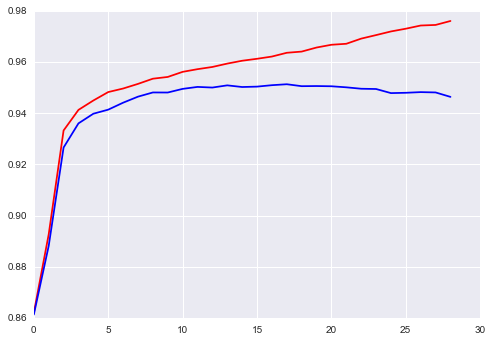

In [13]:
plt.plot(np.arange(0,n_epochs-1,1), train_aucs[0:n_epochs-1], 'r-', np.arange(0,n_epochs-1,1), test_aucs[0:n_epochs-1],'b-')

## Tested just on 9 mers

In [79]:
test_idx_9 = np.array([i for i in test_idx if np.count_nonzero(X[i]) == 9])

In [83]:
len(test_idx)-len(test_idx_9)

525

In [85]:
roc_auc_score(measured_affinity_less_than(y[test_idx_9],500),model.predict(X[test_idx_9]))

0.95512319801258849